# Import dataset

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('feature_selection.csv').drop(columns = ['Unnamed: 0'])

# one type named as 'rn' while others are 'RN'
df['type'] = df['type'].apply(lambda x: 'RN' if x == 'rn' else x.strip())

# keep only prevstatus or status = confirmed
df = df[df.apply(lambda row: (row['prevStatus'] == 'confirmed') or (row['status'] == 'confirmed'), 
                 axis = 1)].reset_index(drop = True)

# CW_Time2Start_Time columns has many nan
df = df.fillna(0)

In [2]:
df.columns

Index(['id', 'user_id', 'shift_id', 'facility_id', 'withdrawninfo_value',
       'status', 'prevStatus', 'distance', 'shift_description',
       'assigned_nurse_id', 'net_pay', 's_unit', 'type', 's_qualifications',
       's_breakTime', 'withdrawnInfo', 'f_name', 'f_short_name', 'segmentName',
       'areaName', 's_create', 'sa_create', 'u_approve', 'u_create',
       'sa_statusupdate', 'Start_Time', 'U_create2U_approve', 'U_create2now',
       'U_approve2now', 'S_create2SA_Create', 'SA_Create2Start_Time',
       'S_Create2Start_Time', 'CW_Time2Start_Time', 'target', 'count_prev_SA',
       'count_prev_CW', 'prev_CW/SA_rate', 'prev_CW x SA_rate',
       'Str_Start_Time', 'start_date', 'CW_in_a_month'],
      dtype='object')

# <font color = blue> Select categorical variables

### Feature selection using chi-squared statistical hypothesis test
* Test set couldnt include all facility ids, makes result inaccessible

                 score
type         10.783081
segmentName  13.821743
areaName      2.999222
f_name       98.613822


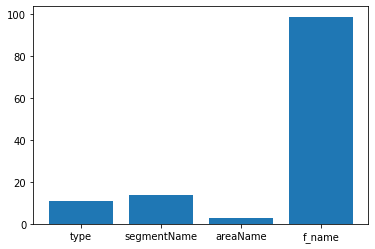

In [23]:
# feature selection using chi-squared statistical hypothesis test
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot


# OrdinalEncoder() for features
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc


def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return X_train_enc, X_test_enc

def select_feature_chi(X_train, y_train, X_test):
    fs = SelectKBest(score_func = chi2, k = 'all') # k: number of top features to select
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs


# load dataset
X = df[['type', 'segmentName', 'areaName', 'f_name']].values
y = df['target'].values

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

# # prepare output data
# y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
y_train_enc = y_train

# feature selection
X_train_fs, X_test_fs, fs = select_feature_chi(X_train_enc, y_train_enc, X_test_enc)

# what are scores for the features
print(pd.DataFrame(fs.scores_, index = ['type', 'segmentName', 'areaName', 'f_name'], columns = ['score']))
# plot the scores
pyplot.bar(['type', 'segmentName', 'areaName', 'f_name'], fs.scores_)
pyplot.show()

### Mutual information feature selection for categorical data


                score
type         0.005957
segmentName  0.009670
areaName     0.005671
f_name       0.011575


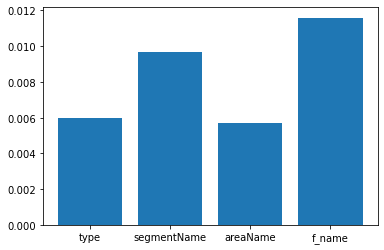

In [24]:
from sklearn.feature_selection import mutual_info_classif

def select_feature_IG(X_train, y_train, X_test):
    fs = SelectKBest(score_func = mutual_info_classif, k = 'all') # k: number of top features to select
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_feature_IG(X_train_enc, y_train_enc, X_test_enc)

# what are scores for the features
print(pd.DataFrame(fs.scores_, index = ['type', 'segmentName', 'areaName', 'f_name'], columns = ['score']))
# plot the scores
pyplot.bar(['type', 'segmentName', 'areaName', 'f_name'], fs.scores_)
pyplot.show()

# <font color = blue> Select Numerical variables

### Anova f-test feature selection for numerical data

                           score
prev_CW/SA_rate       743.985536
U_approve2now         428.619283
count_prev_CW         401.480438
U_create2now          375.540581
CW_in_a_month         373.380553
SA_Create2Start_Time  156.278139
S_create2SA_Create    129.371991
prev_CW x SA_rate      71.906874
count_prev_SA          71.186375
s_breakTime            59.209209
net_pay                40.404107
U_create2U_approve      3.658496
S_Create2Start_Time     3.236463


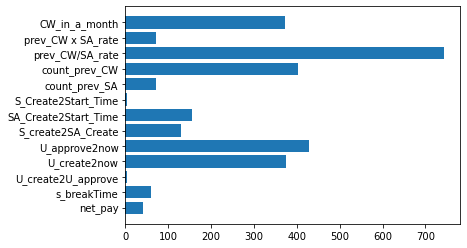

In [25]:
from sklearn.feature_selection import f_classif

# feature selection
def select_features_f(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func = f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# load dataset
test_df = df[['net_pay', 's_breakTime','U_create2U_approve', 'U_create2now',
              'U_approve2now', 'S_create2SA_Create', 'SA_Create2Start_Time',
              'S_Create2Start_Time', 'count_prev_SA',
              'count_prev_CW', 'prev_CW/SA_rate', 'prev_CW x SA_rate', 'CW_in_a_month']]
X = test_df.values
y = df['target'].values

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# feature selection
X_train_fs, X_test_fs, fs = select_features_f(X_train, y_train, X_test)

# what are scores for the features
print(pd.DataFrame(fs.scores_, index = list(test_df.columns), 
                   columns = ['score']).sort_values(by = 'score', ascending = False))

# plot the scores
pyplot.barh(list(test_df.columns), fs.scores_)
pyplot.show()

### Grid search

In [32]:
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV

# # feature selection
# def select_features_f(X_train, y_train, X_test):
#     # configure to select all features
#     fs = SelectKBest(score_func = f_classif, k='all')
#     # learn relationship from training data
#     fs.fit(X_train, y_train)
#     # transform train input data
#     X_train_fs = fs.transform(X_train)
#     # transform test input data
#     X_test_fs = fs.transform(X_test)
#     return X_train_fs, X_test_fs, fs

# # load dataset
# test_df = df[['net_pay', 's_breakTime','U_create2U_approve', 'U_create2now',
#               'U_approve2now', 'S_create2SA_Create', 'SA_Create2Start_Time',
#               'S_Create2Start_Time', 'count_prev_SA',
#               'count_prev_CW', 'prev_CW/SA_rate', 'prev_CW x SA_rate', 'CW_in_a_month']]
# X = test_df.values
# y = df['target'].values

# # define the evaluation method
# # stratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the 
# # same percentage of samples of each target class as the complete set
# # n_splits: number of folds
# # n_repeats: number of times cross-validator need to be repeated
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# # define the pipeline to evaluate
# model = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced')
# fs = SelectKBest(score_func = f_classif) #
# pipeline = Pipeline(steps=[('anova', fs), ('lr',  model)])

# # define the grid
# grid = dict()
# grid['anova__k'] = [i+1 for i in range(X.shape[1])]

# # define the grid search
# # estimator : this is assumed to implement the scikit learn estimator interface
# # param_grid: dictionary with parameters names as keys and list of parameter settings to try as values
# # scoring: evaluation metric to use when ranking results
# # n_jobs: number of jobs to run in parallel, -1 means using all processors 
# # cv: number of cv folds for each combination of parameters
# search = GridSearchCV(pipeline, grid, scoring='precision', n_jobs = 5, cv=cv)

# # perform the search
# results = search.fit(X, y)

# # summarize best
# print('Best Precision: %.3f' % results.best_score_)
# print('Best Config: %s' % results.best_params_)

### With mutual information

                         score
U_create2now          0.032268
U_approve2now         0.031928
net_pay               0.031198
U_create2U_approve    0.024303
prev_CW/SA_rate       0.006866
s_breakTime           0.006593
prev_CW x SA_rate     0.006407
S_create2SA_Create    0.004793
SA_Create2Start_Time  0.004609
count_prev_CW         0.004132
CW_in_a_month         0.003950
count_prev_SA         0.002298
S_Create2Start_Time   0.002226


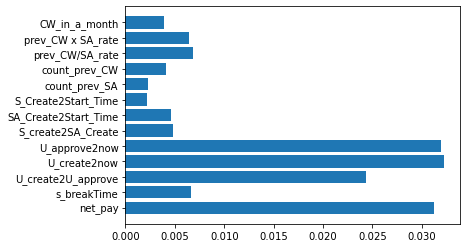

In [27]:
from sklearn.feature_selection import mutual_info_classif


# feature selection
def select_features_IG_num(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func = mutual_info_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features_IG_num(X_train, y_train, X_test)

# what are scores for the features
print(pd.DataFrame(fs.scores_, index = list(test_df.columns), 
                   columns = ['score']).sort_values(by = 'score', ascending = False))

# plot the scores
pyplot.barh(list(test_df.columns), fs.scores_)
pyplot.show()

### compare performance num of features-mutual information

>1 0.571 (0.048)
>2 0.554 (0.006)
>3 0.552 (0.007)
>4 0.561 (0.013)
>5 0.585 (0.030)
>6 0.573 (0.033)
>7 0.561 (0.017)
>8 0.565 (0.019)
>9 0.577 (0.009)
>10 0.584 (0.018)
>11 0.607 (0.019)
>12 0.607 (0.017)
>13 0.609 (0.014)


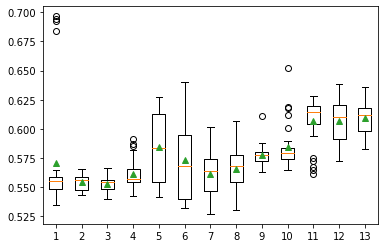

In [34]:
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# load dataset
test_df = df[['net_pay', 's_breakTime','U_create2U_approve', 'U_create2now',
              'U_approve2now', 'S_create2SA_Create', 'SA_Create2Start_Time',
              'S_Create2Start_Time', 'count_prev_SA',
              'count_prev_CW', 'prev_CW/SA_rate', 'prev_CW x SA_rate', 'CW_in_a_month']]
X = test_df.values
y = df['target'].values


# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores
# define number of features to evaluate
num_features = [i+1 for i in range(X.shape[1])]

# enumerate each number of features
results = list()
for k in num_features:
    # create pipeline
    model = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced')
    fs = SelectKBest(score_func = mutual_info_classif, k=k)
    pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
    # evaluate the model
    scores = evaluate_model(pipeline, X, y)
    results.append(scores)
    # summarize the results
    print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=num_features, showmeans=True)
pyplot.show()

# <font color = blue> Use RFE for feature selection
* Recursive Feature Elimination

### Automatically select the number of features for RFE & report feature rank

In [29]:
from sklearn.preprocessing import OrdinalEncoder


# numerical column name
num_colname = ['net_pay', 's_breakTime','U_create2U_approve', 'U_create2now',
               'U_approve2now', 'S_create2SA_Create', 'SA_Create2Start_Time',
               'S_Create2Start_Time', 'count_prev_SA', 'count_prev_CW', 
               'prev_CW/SA_rate', 'prev_CW x SA_rate', 'CW_in_a_month']
# categorical column name
cat_colname = ['type', 'segmentName', 'areaName', 'f_name']


# categorical
X = df[cat_colname].values
oe = OrdinalEncoder()
oe.fit(X)
X_enc = oe.transform(X)
X_dummy = pd.DataFrame(X_enc, columns = cat_colname)
# concat with numberical - feature
X = pd.concat([df[num_colname], X_dummy], axis = 1)

# target
y = df['target']

In [30]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE


# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select = 7)
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
    print('Column: %d, Selected=%s, Rank: %d' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected=True, Rank: 1
Column: 1, Selected=False, Rank: 9
Column: 2, Selected=False, Rank: 3
Column: 3, Selected=False, Rank: 4
Column: 4, Selected=True, Rank: 1
Column: 5, Selected=True, Rank: 1
Column: 6, Selected=True, Rank: 1
Column: 7, Selected=True, Rank: 1
Column: 8, Selected=True, Rank: 1
Column: 9, Selected=False, Rank: 8
Column: 10, Selected=False, Rank: 2
Column: 11, Selected=False, Rank: 5
Column: 12, Selected=False, Rank: 10
Column: 13, Selected=False, Rank: 7
Column: 14, Selected=False, Rank: 11
Column: 15, Selected=False, Rank: 6
Column: 16, Selected=True, Rank: 1


In [31]:
X

,net_pay,s_breakTime,U_create2U_approve,U_create2now,U_approve2now,S_create2SA_Create,SA_Create2Start_Time,S_Create2Start_Time,count_prev_SA,count_prev_CW,prev_CW/SA_rate,prev_CW x SA_rate,CW_in_a_month,type,segmentName,areaName,f_name
0,40.0,0.0,0.000000,32.429831,0.000000,0.029823,0.235789,0.265612,0,0,0.0,0,0,4.0,1.0,3.0,187.0
1,30.0,0.0,5305.129378,32.429831,25.167358,0.011317,2.008072,2.019389,4,0,0.0,0,0,6.0,1.0,3.0,187.0
2,45.0,0.0,5305.129378,32.429831,25.167358,0.005437,0.038918,0.044354,7,0,0.0,0,0,4.0,1.0,3.0,187.0
3,40.0,0.0,5305.129378,32.429831,25.167358,72.900516,22.122296,95.022811,6,0,0.0,0,0,4.0,1.0,3.0,187.0
4,45.0,0.0,5305.129378,32.429831,25.167358,0.003420,9.731844,9.735264,8,0,0.0,0,0,4.0,1.0,3.0,187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67131,30.0,30.0,14.607588,0.217446,0.197452,239.708428,448.297171,688.005599,1,0,0.0,0,1,3.0,1.0,2.0,277.0
67132,12.5,0.0,51.556530,0.121269,0.050693,21.010757,71.742966,92.753723,0,0,0.0,0,0,1.0,1.0,3.0,211.0
67133,15.0,30.0,15.087454,0.073117,0.052466,0.029436,99.153814,99.183249,0,0,0.0,0,0,0.0,1.0,3.0,305.0
67134,20.0,30.0,14.344444,0.055543,0.035909,223.255459,81.171369,304.426828,0,0,0.0,0,0,5.0,1.0,1.0,61.0


In [ ]:
num_colname = ['net_pay', 's_breakTime','U_create2U_approve', 'U_create2now',
               'U_approve2now', 'S_create2SA_Create', 'SA_Create2Start_Time',
               'S_Create2Start_Time', 'count_prev_SA', 'count_prev_CW', 
               'prev_CW/SA_rate', 'prev_CW x SA_rate', 'CW_in_a_month']

In [32]:
X_1 = X[['prev_CW/SA_rate', 'U_approve2now', 'count_prev_CW', 'U_create2now', 
         'CW_in_a_month', 'SA_Create2Start_Time', 'S_create2SA_Create', 
         'prev_CW x SA_rate', 'count_prev_SA', 's_breakTime', 'net_pay']]

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.30)

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

logit = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', max_iter = 100000)
logit.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=100000)

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = logit.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[11459  7362]
 [  465   855]]


              precision    recall  f1-score   support

           0       0.96      0.61      0.75     18821
           1       0.10      0.65      0.18      1320

    accuracy                           0.61     20141
   macro avg       0.53      0.63      0.46     20141
weighted avg       0.90      0.61      0.71     20141



In [45]:
y_pred_prob = logit.predict_proba(X_test)

In [58]:
t = pd.DataFrame(list(zip(y_pred_prob[:,1], y_test)), columns = ['pred', 'true'])
t

,pred,true
0,0.659077,0
1,0.575098,1
2,0.286337,0
3,0.212562,0
4,0.588676,0
...,...,...
20136,0.638406,0
20137,0.462912,0
20138,0.594409,0
20139,0.206236,0


In [61]:
import statistics
mean(t[t['true'] == 1]['pred'])

0.5501521012824272

In [62]:
mean(t[t['true'] == 0]['pred'])

0.4523860738963099